In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=5

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=5


In [2]:
# import torch
import jax
import jax.numpy as jnp
import flax
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML
from functools import partial
import json
from entmax_jax.activations import sparsemax, entmax15
from meta_expl.explainers import load_explainer, create_explainer
from meta_expl.models import load_model, create_model
from meta_expl.data.cifar100 import dataloader, load_data

### define args

In [3]:
# arguments
arch = 'vit-base'
setup = 'static_teacher'  # "no_teacher", "static_teacher", "learnable_teacher"
seed = 9
batch_size = 16
max_len = 32*32
num_classes = 100
task_type = "classification"
modality = "image"

teacher_dir = 'data/cifar100-vit-models/teacher_dir'
teacher_expl_dir = 'data/cifar100-vit-models/teacher_expl_dir'
student_dir = 'data/cifar100-vit-models/student_dir'
student_expl_dir = 'data/cifar100-vit-models/student_expl_dir'

In [4]:
from transformers import ViTFeatureExtractor
tokenizer = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
vocab_size = None

In [5]:
# create dummy inputs for model instantiation
dummy_inputs = {"pixel_values": jnp.ones((batch_size, 3, 224, 224))}

### load models and explainers

In [ ]:
%env XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false
%env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/local/cuda/

In [8]:
teacher, teacher_params, dummy_state = load_model(teacher_dir, dummy_inputs, batch_size, max_len)
teacher_explainer, teacher_explainer_params = load_explainer(teacher_expl_dir, dummy_inputs, state=dummy_state)
student, student_params, dummy_state = load_model(student_dir, dummy_inputs, batch_size, max_len)
student_explainer, student_explainer_params = load_explainer(student_expl_dir, dummy_inputs, state=dummy_state)

In [131]:
from meta_expl.utils import PRNGSequence
keyseq = PRNGSequence(seed)

teacher_explainer_params_non_trained={
    'normalize_head_coeffs': 'sparsemax',
    'normalizer_fn': 'softmax',
    'aggregator_idx': 'mean',
    'aggregator_dim': 'row',
    'init_fn': 'uniform',
    'layer_idx': None,
    'head_idx': None
}

# teacher, teacher_params, dummy_state = create_model(
#     key=next(keyseq),
#     inputs=dummy_inputs,
#     vocab_size=1,
#     num_classes=num_classes,
#     arch=arch,
#     batch_size=batch_size,
#     max_len=max_len,
#     embeddings=None,
# )
teacher_explainer_non_trained, teacher_explainer_params_non_trained = create_explainer(
    key=next(keyseq),
    inputs=dummy_inputs,
    state=dummy_state,
    explainer_type='attention_explainer',
    explainer_args=teacher_explainer_params_non_trained,
)

### look at the coefficients

In [137]:
sparsemax(teacher_explainer_params_non_trained['params']['head_coeffs']).reshape(12, 12)

DeviceArray([[0.00694444, 0.00694444, 0.00694444, 0.00694444, 0.00694444,
              0.00694444, 0.00694444, 0.00694444, 0.00694444, 0.00694444,
              0.00694444, 0.00694444],
             [0.00694444, 0.00694444, 0.00694444, 0.00694444, 0.00694444,
              0.00694444, 0.00694444, 0.00694444, 0.00694444, 0.00694444,
              0.00694444, 0.00694444],
             [0.00694444, 0.00694444, 0.00694444, 0.00694444, 0.00694444,
              0.00694444, 0.00694444, 0.00694444, 0.00694444, 0.00694444,
              0.00694444, 0.00694444],
             [0.00694444, 0.00694444, 0.00694444, 0.00694444, 0.00694444,
              0.00694444, 0.00694444, 0.00694444, 0.00694444, 0.00694444,
              0.00694444, 0.00694444],
             [0.00694444, 0.00694444, 0.00694444, 0.00694444, 0.00694444,
              0.00694444, 0.00694444, 0.00694444, 0.00694444, 0.00694444,
              0.00694444, 0.00694444],
             [0.00694444, 0.00694444, 0.00694444, 0.00694444, 0.0

In [9]:
sparsemax(teacher_explainer_params['params']['head_coeffs']).reshape(12, 12)

DeviceArray([[0.        , 0.        , 0.03754304, 0.03200413, 0.        ,
              0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        ],
             [0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        , 0.07093407, 0.        , 0.        ,
              0.        , 0.        ],
             [0.02360005, 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.04277126],
             [0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        ],
             [0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        ],
             [0.        , 0.        , 0.        , 0.        , 0.0

In [10]:
hc = sparsemax(teacher_explainer_params['params']['head_coeffs']).reshape(12, 12)
for a, b in zip(*hc.nonzero()):
    print(a, b, hc[a,b])

0 2 0.037543043
0 3 0.032004133
1 7 0.07093407
2 0 0.023600047
2 11 0.042771257
5 4 0.057434496
5 6 0.020644484
6 10 0.026544234
10 0 0.029145654
10 1 0.05205636
10 2 0.0201117
10 4 0.0227738
10 5 0.041795414
10 6 0.019926744
10 7 0.028310832
10 8 0.018509509
10 10 0.005542064
11 0 0.07020469
11 1 0.017539144
11 2 0.050467845
11 4 0.0834601
11 5 0.035108786
11 6 0.04038902
11 7 0.029967437
11 8 0.043612216
11 9 0.03187661
11 11 0.047726218


### load data

In [11]:
train_data = load_data(setup, "train")
valid_data = load_data(setup, "valid")
test_data = load_data(setup, "test")
labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'cra', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm',]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [118]:
labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'cra', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm',]

## plot some samples

In [127]:
test_data[0]

{'img': <PIL.Image.Image image mode=RGB size=32x32 at 0x7F5D38217940>,
 'fine_label': 60,
 'coarse_label': 10}

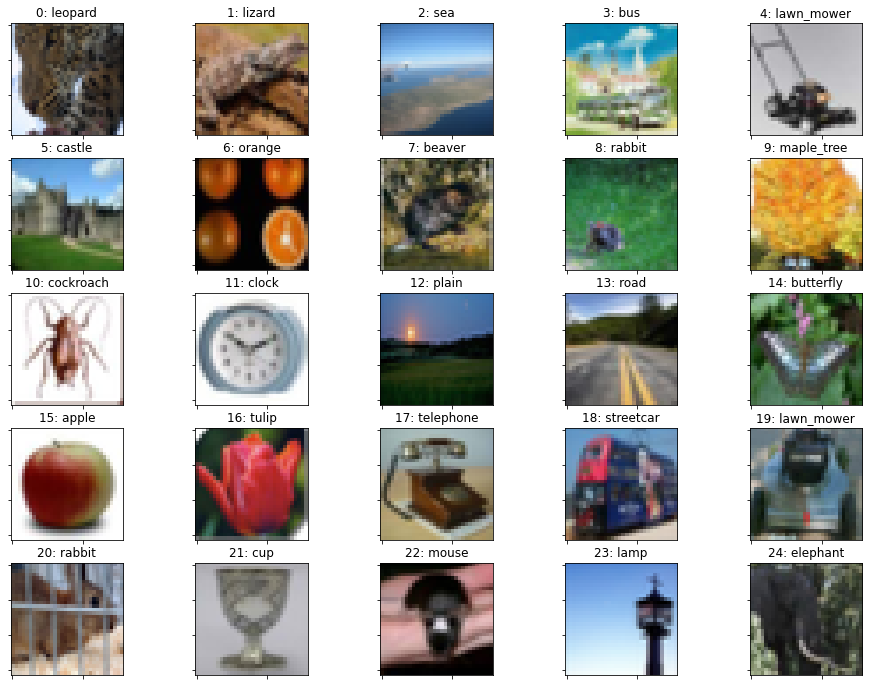

In [128]:
fig, axs = plt.subplots(5, 5, figsize=(16, 12))
for i in range(25):
    ax = axs[i//5, i%5]
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    sample = test_data[i+100]
    ax.imshow(sample['img'])
    ax.set_title('{}: {}'.format(i, labels[sample['fine_label']]))

## plot explanations

In [14]:
from captum.attr import visualization

In [133]:
def get_expl(data, idx=0, non_trained=False):
    x, y = next(dataloader([data[idx]], tokenizer=tokenizer, batch_size=1, max_len=None, shuffle=False))
    y_teacher, teacher_attn = teacher.apply(teacher_params, **x, deterministic=True)
    if non_trained:
        teacher_expl, _ = teacher_explainer_non_trained.apply(teacher_explainer_params_non_trained, x, teacher_attn)
    else:
        teacher_expl, _ = teacher_explainer.apply(teacher_explainer_params, x, teacher_attn)
    y_student, student_attn = student.apply(student_params, **x)
    student_expl, _ = student_explainer.apply(student_explainer_params, x, student_attn)
    teacher_rep = teacher_attn['hidden_states'][0][0]
    teacher_attn = np.asarray(jnp.stack(teacher_attn['attentions']).transpose([1, 0, 2, 3, 4]))
    student_attn = np.asarray(jnp.stack(student_attn['attentions']).transpose([1, 0, 2, 3, 4]))
    return {
        'teacher_attn': teacher_attn[0],
        'teacher_expl': teacher_expl.tolist()[0],
        'teacher_rep': teacher_rep.tolist()[1:],
        'student_attn': student_attn[0],
        'student_expl': student_expl.tolist()[0],
        'y_teacher': np.argmax(y_teacher.tolist()[0]),
        'y_student': np.argmax(y_student.tolist()[0]),
        'x': x['pixel_values'][0].transpose([1, 2, 0]),
        'y': y[0],
        'x_img': data[idx]['img'],
    }


In [134]:
def show_expl(data, idx=0, non_trained=False):
    d = get_expl(data, idx, non_trained=non_trained)
    # x = np.asarray(d['x'])
    x = np.asarray(d['x_img'].resize((224, 224)))
    expl = np.asarray(d['teacher_expl'])
    # remove cls token
    e = expl[1:].reshape(14, 14)
    # repeat interleave for each patch
    e = np.repeat(np.repeat(e, 16, axis=0), 16, axis=1)
    # add dummy dim
    e = e[:, :, None]
    
    print('y_teacher:', labels[d['y_teacher']])
    print('y_student:', labels[d['y_student']])
    visualization.visualize_image_attr_multiple(e, x, 
                                                methods=['original_image', 'heat_map', 'alpha_scaling'],
                                                signs=['positive', 'positive', 'positive'],
                                                titles=['original', 'raw explanation', 'overlay explanation'],
                                                fig_size=(6, 3))
    return d

y_teacher: butterfly
y_student: butterfly


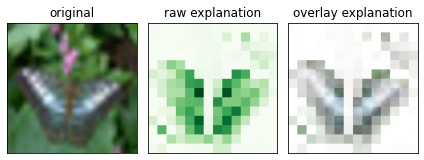

In [130]:
d = show_expl(test_data, idx=114)

y_teacher: butterfly
y_student: butterfly


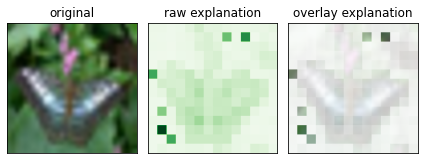

In [135]:
d = show_expl(test_data, idx=114, non_trained=True)

y_teacher: television
y_student: television


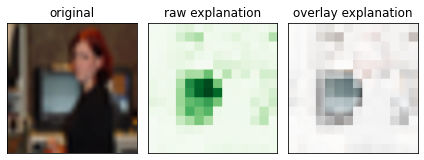

In [141]:
d = show_expl(test_data, idx=5)

y_teacher: television
y_student: television


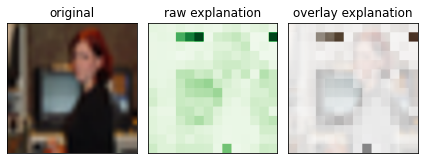

In [136]:
d = show_expl(test_data, idx=5, non_trained=True)

y_teacher: worm
y_student: worm


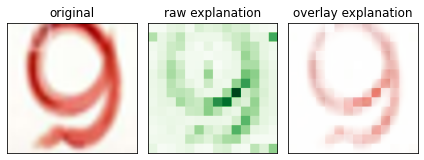

In [122]:
d = show_expl(test_data, idx=2)

## plot patches 16x16 patches

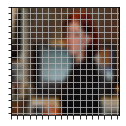

In [146]:
# Set the gridding interval: here we use the major tick interval
import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=14)

# Add the grid
fig, ax = plt.subplots(figsize=(2, 2))
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which='major', axis='both', linestyle='-')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.imshow(d['x_img'].resize((244, 244)))

## plot attention maps

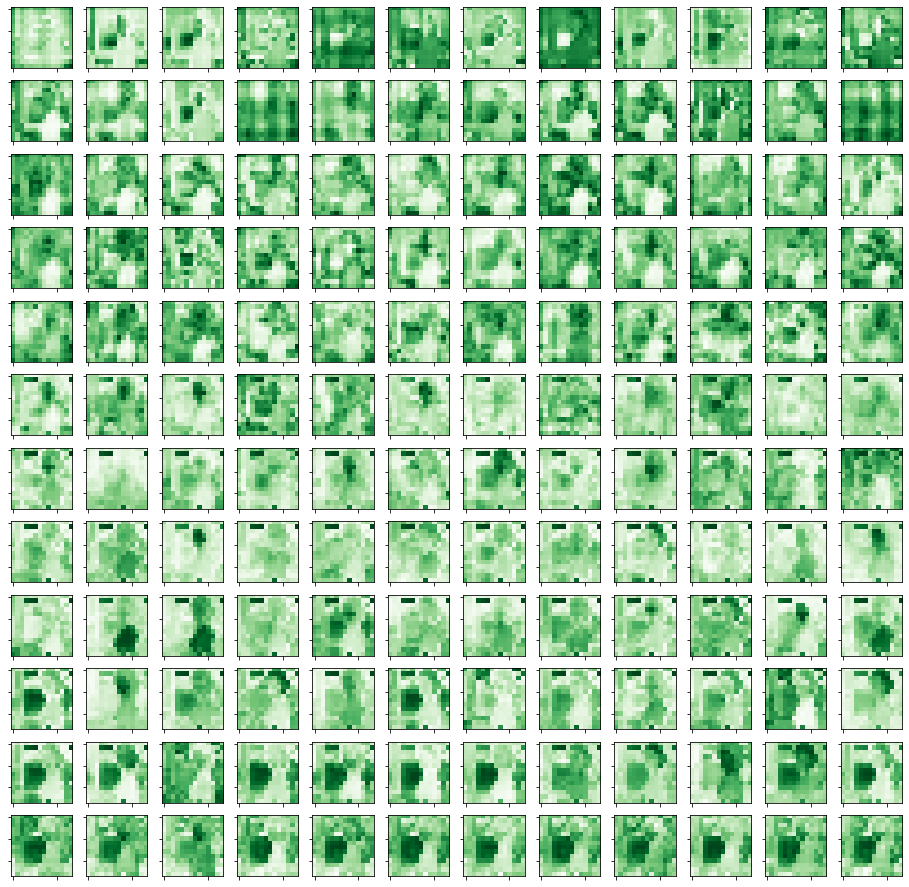

In [149]:
row_id = 0
heads_expl = d['teacher_attn']

fig, axs = plt.subplots(12, 12, figsize=(16, 16))

for l in range(12):
    for i in range(12):
        ax = axs[l, i]
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.imshow(heads_expl[l, i, row_id, 1:].reshape(14, 14), cmap='Greens')